# Lab: Growth functions and population dynamics

<div class="alert alert-warning">
If figures/tables are not rendered correctly, make sure your notebook is `trusted` by running `Trust Notebook` operation found in `Commands` (third icon from the top on the toolbar located left-hand side). You can easily find this menu by typing in "trust" in the search box there.
</div>

<div class="alert alert-info">
This is a student version of the notebook that some portions of code may be redacted with comments like `#= .. =#`. Students are encouraged to complete the code to get same/similar results as rendered in the notebook. A complete version of the notebook will be provided once the lab session is finished each week.
</div>

In [ ]:
using Cropbox, CSV, DataFrames

## Exponential growth

A simple exponential growth fuction can be written as:

- Eqn 2.1
$$
\frac{dW}{dt} = rW
$$

Assuming this relatioship during the growth, the relative growth rate (RGR; $r$) can be obtained from two biomass measurements ($W{_1}$ and $W{_2}$) (or height ($H$) or other measures of growth) measured at two time points ($t{_1}$ and $t{_2}$) as shown in Eqn 2.4.
- Eqn 2.3.

$$
r = \frac{\ln{W_2} - \ln{W_1}}{t_2 - t_1}
$$


## Ex 2.1. Douglas-fir early height growth

In Chapter 1, we've estimated the absolute growth rate (AGR; $\mathrm{m \cdot yr^{-1}}$) of Douglas-fir saplings grown in Marin County, CA in the first few decades of their life based on a figure from Porzig et al. (2014). Table shown below provide mean tree heights over 20 year period with 10 year intervals. Calculate the relative growth rate (RGR; $r$) for each 10 year period (i.e., 1985 - 1995 and 1995 - 2005) and over the entire 20 year period (1985 - 2005), and compare their values. These trees are in relatively early stage of their growth. Do you think the exponential growth model does a good job of describing their growth pattern? How do RGRs from this problem compare with the AGR from Q1.1 in Chapter 1? What are their units?


| Year | Height (m)
| :- | :- |
| 1985 | 1.68 |
| 1995 | 2.56 |
| 2005 | 6.99 |

In [ ]:
r(t1, t2; H1, H2) = (log(H2)-log(H1))/(t2-t1)

In [ ]:
r(1985,2005; H1 = 1.68, H2 = 6.99)

Let's recall the simple exponential growth model from Lab 01 and enter the parameter values we got.  Exact age of the trees when the measurements were made was unknown. But the mean initial height ($H_0$) of the trees was 1.42m in 1983 when the first measurements were made.

Note that we are ignoring units here but an important feature of `Cropbox` is the accounting of all units used in the model. We will revisit this later.

In [ ]:
@system DF_exp(Controller) begin
    H0      => 1.42  ~ preserve
    r       => 0.071  ~ preserve(parameter)
    H(r,H)  => r*H   ~ accumulate(init = H0)
    yr      => 1     ~ accumulate(init = 1983)
end

In [ ]:
visualize(DF_exp, :yr, :H; stop = 27, kind = :line)

In [ ]:
DF_obs = CSV.read("PSME-height.csv", DataFrame) |> unitfy; 
# keeping the correct unit is a key in Cropbox. We will talk more about this.

Let's overlay the digitized data with our model. How did did the model do? How does it compare with the linear model we worked on in Lab 01? Which model would you choose to use and why?

In [ ]:
p = visualize(DF_obs, :year, :height; )
visualize!(p, DF_exp, :yr, :H; stop=27, kind = :line)

## Logistic growth

One of the most widely used growth models is the logistsic function for its intuitive parameters that are relatable to biological traits and ecological concepts. For example, if we assume that a plant grows through cell division and expansion at a rate proportional to the existing cells and their biomass with little to no physical or physiological limitations, the early growth rate is likely to resemble that of the exponential growth growth. However, as the plant grows bigger and taller the growth rate will slow down. This may be because the plant is approaching its ceiling for height and biomass that's controlled by genetic, physiological, or physcal limits (e.g., maximal height; $H_f$). The logistic function provides a useful mathematical formula to describe this growth pattern. The plant height growth may be written as: 

- Differential equation of logistic height growth

$$
\frac{dH}{dt} = rH(1-\frac{H}{H_f}) = rH(\frac{H_f-H}{H_f})
$$

Where $H$ is plant height, $H_f$ is the final or potential height, and $r$ is the initial growth rate. More often than not though the final height or potential capacity is unknown. 

## Ex 2.2. Douglas-Fir height growth to maturity with a logistic function

A Douglas-Fir tree may grow up to 70m in height when mature if grown at a high quality site. 

- Create a `Cropbox` system that simulates Douglas-Fir tree growth at a high quality site over 200 years using the logistic equation
- Recreate Figure 2.1a for a high quality site
- Recreate Figure 2.1b for a high quality site
- Compare your results with the original figures and discuss. How would you grade this model's performance to describe Douglas-fir growth and why?

In [ ]:
@system DF_logi(Controller) begin
    H0         => 1.42               ~ preserve
    r          => 0.07               ~ preserve(parameter)
    Hf         => 70.0               ~ preserve(parameter)
    H(r,H,Hf)  => r*H*(1.0 - H/Hf)   ~ accumulate(init = H0)
    yr         => 1                  ~ accumulate(init = 1983)
    dH(r,H,Hf) => r*H*(1.0 - H/Hf)   ~ capture # This "state verb" or command captures the changes occuring at each time step
end

In [ ]:
p = visualize(DF_obs, :year, :height; xlim = (1983, 2183), ylim = (0, 75))
visualize!(p, [DF_logi], :yr, :H; stop=200, kind = :line)

In [ ]:
visualize([DF_logi], :H, :dH; stop=200, kind = :line)

## Ex 2.3. Logistic growth for corn biomass

Incorporate the differential equation (Eqn 2.5) and an analytical solution (Eqn 2.5) of the logistic equation using *Cropbox* package. Using the parameter values in Table 2.1, simulate both forms of the logistic model for 300 days on *daily time steps*. Plot to overlay the two forms in one figure and compare the results. Before running simulations, predict if you expect the results from both models to be identical? Why or why not? Do your simulations support your predictions? Why or why not? Test the behavior of the model with respect to its parameter values.

### Logistic growth (derivative form)

Here we are going to implement the logistic growth function more fully in `Cropbox` fashion with proper units and time handling to describe the growh of a highly productive annual crop (e.g., corn) in daily time steps. 

- Eqn 2.4.

$$
\frac{dW}{dt} = rW(1-\frac{W}{W_f}) = rW(\frac{W_f-W}{W_f})
$$

- Table 2.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $r$ | 0.05 | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Relative (or specific or intrinsic) growth rate |
| $W_0$ | 0.25 | $\mathrm{g}$ | Seed mass or initial biomass |
| $W_f$ | 300 | $\mathrm{g}$ | Potential final mass of a plant |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter (state variable) |

Here is the model specification of Eqn 2.4 implemented on Cropbox framework. See how variables and parameters are declared each line with state verbs (`track`, `preserve`, `accumulate`) and tags (*i.e.* `parameter`, `init`, `u".."`).

- Time variable `t` is set to `track` internal time variable (`context.clock.tick`) in the unit of `d` (day) which is a conversion from default `hr` (hour).
- Parameters `r`, `W0`, `Wf` are set to `preserve` their initial values which are declared in the body. They are tagged `parameter` indicating their values may be replaced by configuration when running simulations.
- As the state variable `W` is defined as a form of derivative ($\frac{dW}{dt}$), we want to integrate its value over time. As Cropbox is essentially a discrete-time modeling framework, what we do here is `accumulate` (summing up) instead of integration over continous time.

In [ ]:
@system Eq24(Controller) begin
    t(context.clock.tick) ~ track(u"d")
    
    r: relative_growth_rate => 0.05 ~ preserve(u"g/g/d", parameter)
    W0: initial_biomass => 0.25 ~ preserve(u"g", parameter)
    Wf: potential_final_biomass => 300 ~ preserve(u"g", parameter)
    
    W(r, W, Wf): biomass => begin
        r * W * (Wf - W) / Wf
    end ~ accumulate(u"g", init=W0)
end

`simulate(<System>; ..)` function make an instance of the model system and run simulation until `stop` condition is met. Here we use `300u"d"` as a stop condition which indicates the simulation should run for 300 days. The output of `simulate()` is a table-like DataFrame with columns from variables specified in the model.

In [ ]:
r24 = simulate(Eq24; stop=300u"d")

We can draw a graph with `plot(<DataFrame>, <x>, <y>; ..)` function with the DataFrame output. By default, `kind` option is set to `:scatter` which could be inefficient to plot too many data points, so we instead decided to use `:line` to draw a line plot.

In [ ]:
plot(r24, :t, :W; kind=:line)

#### Clock and Configulation

Note that models in Cropbox have a default clock set in hourly time step (`context.clock.step`). We may change the time step by providing a user configuration. Configuration is in a two-level mapping like `<System> => <Variable> => <Value>`. Cropbox supports many different ways of constructing construction and one simple way is to use a pair of pair.

In [ ]:
c = :Clock => :step => 1u"d"

Here we make a configuration `c` for system `Clock` and want to have its variable `step` to be `1u"d"` (1 day). We can take a look at how this pair of pair structure transformed into an actual instance of configuration by calling `configure()` or `@config`.

In [ ]:
@config(c)

Now we re-run the simulation with the custom configuration `c` for daily time step.

In [ ]:
r24 = simulate(Eq24; config=c, stop=300u"d")

In [ ]:
plot(r24, :t, :W; kind=:line)

### Logisitc growth (integrated form): This is an analytical solution of Eqn. 2.5

- Eqn 2.5.

$$
W = \frac{W_0 W_f}{W_0 + (W_f-W_0)e^{-rt}} = \frac{W_f}{1 + (\frac{W_f}{W_0}-1)e^{-rt}}
$$

- Table 2.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $r$ | 0.05 | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Relative (or specific or intrinsic) growth rate |
| $W_0$ | 0.25 | $\mathrm{g}$ | Seed mass or initial biomass |
| $W_f$ | 300 | $\mathrm{g}$ | Potential final mass of a plant |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter (state variable) |

Specification of system `Eq25` looks very similar to `Eq24` except the state variable `W` is already in the form of integral, not a derivative. Thus, what we need to do is just to make sure re-calculate `W` to `track` its value every time step instead of accumulation / integration.

In [ ]:
@system Eq25(Controller) begin
    t(context.clock.tick) ~ track(u"d")
    
    r: relative_growth_rate => 0.05  ~ preserve(u"g/g/d", parameter)
    W0: initial_biomass => 0.25 ~ preserve(u"g", parameter)
    Wf: potential_final_biomass => 300 ~ preserve(u"g", parameter)
    
    W(r, W0, Wf, t): biomass => begin
        Wf / (1 + (Wf/W0 - 1)* exp(-r*t))
    end ~ track(u"g")
end

In [ ]:
r25 = simulate(Eq25; config=c, stop = 300u"d")

In [ ]:
plot(r25, :t, :W; kind=:line)

#### Plot overlay

We can overlay multiple plots with consecutive calls of `plot!(<Plot>, ...)` with a Plot object returned by previous `plot()` or `plot!()` function.

In [ ]:
p = plot(r24, :t, :W; kind=:line, name="Eq24")
plot!(p, r25, :t, :W; kind=:line, name="Eq25")

Cropbox also provides some high-level plotting functions to make a plot without manually running simulations first. One form of `visualize()` function supports `visualize([<System>..], <x>, <y>; <simulate() options>.., <plot() options..>)` to make an overlay plot in one line.

In [ ]:
visualize([Eq24, Eq25], :t, :W; config=c, stop=300u"d", kind=:line)

You may notice a small difference between two implementations of logistic growth models. Answer the question above and discuss with others.

## Ex 2.4. The Lotka-Volterra model for competition between two species

Create a system to implement the Lotka-Volterra competition model (Eqn 2.8) using $\textit{Cropbox}$. Using the parameter and initial values of your choice, simulate the population dynamics of two annual plant species (e.g., crop and weed) competing for spaces, light, water, and nutrients. Study the system behavior by experimenting with initial conditions and parameter values. Do you think the model demonstrate reasonable predictions that are consistent with your understanding of interspecific competition between two plant species?

- Eqn 2.8

$$
\begin{equation}
\begin{split}    
    \label{eq:LV-compet}
    &\frac{dN_1}{dt} = r_1N_1(1-\frac{N_1+\alpha N_2}{K_1}) = r_1 N_1(\frac{K_1-N_1-\alpha N_2}{K_1})\\
    &\frac{dN_2}{dt} = r_2N_2(1-\frac{N_2+\beta N_1}{K_2}) = r_2 N_2(\frac{K_2-N_2-\beta N_1}{K_2})
\end{split}
\end{equation}
$$

See table 2.1 of the lecture note for parameter definitions.

In [ ]:
@system LV_competition(Controller) begin
    t(context.clock.time) ~ track(u"d")
    N1(r1, α, N1, N2, K1): sp1_population => r1*N1*(K1-N1-α*N2)/K1 ~ accumulate(init = N1_0)
    N2(r2, β, N2, N1, K2): sp2_population => r2*N2*(K2-N2-β*N1)/K2 ~ accumulate(init = N2_0)
    
    N1_0: initial_sp1_population => 100 ~ preserve(parameter)
    N2_0: initial_sp2_population => 20 ~ preserve(parameter)
    
    r1: RGR_sp1 => 0.15 ~ preserve(u"d^-1",parameter)
    r2: RGR_sp2 => 0.2 ~ preserve(u"d^-1",parameter)
    α: effect_of_sp2_on_sp1 => 0.5 ~preserve(parameter)
    β: effect_of_sp1_on_sp2 => 0.2 ~preserve(parameter)
    K1: carrying_capacity_sp1 => 200 ~ preserve(parameter)
    K2: carrying_capacity_sp2 => 200 ~ preserve(parameter)
end

In [ ]:
Cropbox.dependency(LV_competition)

Here, we make a configuration for setting parameters for `LV_competition` system we've just made above. We'll use a daily time step.

In [ ]:
## Stable equillibrium
cLV_c1 = @config (
    :Clock => (;
        step = 1u"d",
    ),
    :LV_competition => (;
        r1 = 0.15, r2 = 0.2,
        α = 0.5, β = 0.2,
        K1 = 200, K2 = 200,
        N1_0 = 100, N2_0 = 20,
    ),
)

In [ ]:
visualize(LV_competition, :t, [:N1, :N2]; config=cLV_c1, stop=200u"d", kind=:line)

In [ ]:
## Unstable equillibrium is the point at which two populations cross
cLV_c2 = @config (
    :Clock => (;
        step = 1u"d",
    ),
    :LV_competition => (;
        r1 = 0.1, r2 = 0.2,
        α = 1.1, β = 1.2,
        K1 = 100, K2 = 100,
        N1_0 = 40, N2_0 = 50,
    ),
)
visualize(LV_competition, :t, [:N1, :N2]; config=cLV_c2, stop=300u"d", kind=:line)

### Equilibria and Isocline Analsis

In popuplation models the concept of equilibrium is important. There may be stable and unstable equilibria for two species in competition to coexisit. For two populations, the isocline ananlysis can provide useful insights to understand the conditions that can lead to stable and unstable equilibria. See Essington (2021) Chapter 4 and Edelstein-Keshet (2005) Chapter 6 for more information. The figure below is borrowed from [Chapter 4 of Essington (2021)](https://doi.org/10.1093/oso/9780192843470.003.0004). It illustrates the X isocline (black line) signifying the population size that X population would move toward (horizontal arrows to grow or shrink) in relation to the size of Y population. The Y isocline (gray line) is for Y population to move toward in vertical direction. Four equilibria are identified in this figure: one stable (d) and three unstable.

<img src="Essington-2021-Ch4-stable-isoclines.png" alt="isoclines" width="500"/>

## Ex 2.5. Density-independent predator-prey interactions

Create a system to implement the density-independent Lotka-Volterra model (Eqn 2.9) using Cropbox package. Using your guesstimates, find the set of parameter values and initial conditions by eyes that mimic the population dynamics shown in Fig. 2.1b. Repeat this process until you are satisfied with the result. What are their values? Do you think those values are ecologically realistic?

### Density-independent Lotka-Volterra model for predator-prey interactions

- Eqn 2.9.

$$
\begin{align}
\frac{dN}{dt} &= rN - aNP \\
\frac{dP}{dt} &= caNP - mP \\
\end{align}
$$

- Table 2.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{yr}$ | Time unit used in the model |
| $N$ | - | - | Prey population as number of individuals (state variable) |
| $P$ | - | - | Predator population as number of individuals (state variable) |
| $r$ | - | $\mathrm{yr^{-1}}$ | Per capita growth rate of prey population |
| $a$ | - | $\mathrm{yr^{-1}}$ | Attack rate or predation rate |
| $c$ | - | - | Conversion efficiency of an eaten prey into new predator; predator's reproduction efficiency per prey consumed) |
| $m$ | - | $\mathrm{yr^{-1}}$ | Mortality rate of predator population |

- Fig. 2.1b

![Fig. 2.1b](http://www2.nau.edu/lrm22/lessons/predator_prey/hare_lynx_graph.png)

Model specification of `LotkaVolterra` resembles what we did with `Eq24` for logistic growth model in a derivative form.

In [ ]:
@system LV_predation(Controller) begin
    t(context.clock.time) ~ track(u"yr")
    
    N(N, P, r, a): prey_population => r*N - a*N*P ~ accumulate(init=N0)
    P(N, P, c, a, m): predator_population => c*a*N*P - m*P ~ accumulate(init=P0)
    
    N0: prey_initial_population ~ preserve(parameter)
    P0: predator_initial_population ~ preserve(parameter)
    
    r: prey_growth_rate ~ preserve(u"yr^-1", parameter)
    a: predation_rate ~ preserve(u"yr^-1", parameter)
    c: predator_reproduction_rate ~ preserve(parameter)
    m: predator_mortality_rate ~ preserve(u"yr^-1", parameter)
end

We can take a look at the dependency between variables declared in the system by calling `Cropbox.dependency(<System>)`.

In [ ]:
Cropbox.dependency(LV_predation)

Similarly, a hierarchy between mix-in systems can be drawn by `Cropbox.hierarchy(<System>)`. Solid line indicates *has* relationship meaning the target system contains an instance of source system. Dashed line indicates *is* relationship meaning the target system is composed of source system as a mix-in.

In [ ]:
Cropbox.hierarchy(LV_predation)

Here, we make a configuration for setting parameters for `LV_predation` system we've just made above. We'll use a daily time step.

In [ ]:
cLV_p = @config (
    :Clock => (;
        step = 1u"d",
    ),
    :LV_predation => (;
        r = 0.6,
        a = 0.02,
        c = 0.5,
        m = 0.5,
        N0 = 20,
        P0 = 30,
    ),
)

Let's make a simulation plot and see how it compares to the original dataset. Note we use a variant `visualize(<System>, <x>, [<y>..]; ..)` with multiple target variables mapped to multiple series of lines.

In [ ]:
visualize(LV_predation, :t, [:N, :P]; config=cLV_p, stop=100u"yr", kind=:line)

Repeat this process until you are satisfied with the result. What are their values? Do you think those values are ecologically realistic?

In [ ]:
@system LV_steady(LV_predation, Controller) begin
    N̄(m, a, c): prey_population_steady_state     => m / (a*c) ~ preserve
    P̄(r, a):    predator_population_steady_state => r / a     ~ preserve
end

In [ ]:
lv = instance(LV_steady; config = cLV_p)

Here we calculate the prey population ($\bar{N}$) that leads to the neutral stability. The vertical line that goes through this point determines the predator nullcline.  

In [ ]:
lv.N̄

Here we calculate the prey population ($\bar{P}$) that leads to the neutral stability. The line going through this point determines the prey nullcline. 

In [ ]:
lv.P̄

Putting the simulation result into a dataframe named `ex23` for Lab exercise 2.3. Note that we use `snap` option to collect output for every 10 days, instead of 1-day interval we set for `Clock`, to avoid potential slowdown and stroage issue caused by a massive amount of data points.

In [ ]:
ex23 = simulate(LV_steady; config = cLV_p, stop = 100u"yr", snap = 10u"d");

Here we use a Julia package called Plots for plotting the phase-plane figure. If the package has not been installed, uncomment the first line to install it once and re-comment it after installling it. 

Study the plot. See where $\bar{N}$ and $\bar{P}$ intersect in the plane and how the N and P populations change with respect to the intersection. Try changing the initial conditions ($N_0$ and $P_0$) closer to $\bar{N}$ and $\bar{P}$ and observe how the model behavior changes.

In [ ]:
p = visualize(ex23, :N, :P;
    name = "N:P",
    xlab = "N (Prey Population)",
    ylab = "P (Predator Population)",
)
p = visualize!(p, lv.P̄'; kind = :hline, name = "P̄ = r/a")
p = visualize!(p, lv.N̄'; kind = :vline, name = "N̄ = m/ac")
p = visualize!(p, [lv.N0'], [lv.P0']; kind = :scatter, name = "Initial point")
p = visualize!(p, [lv.N̄'],  [lv.P̄'];  kind = :scatter, name = "Stable state")

We can save this plot as PDF file using `Cairo` and `Fontconfig` packages. If the packages are not installed, run:
`import Pkg; Pkg.add("Cairo")` and `Pkg.add("Fontconfig")`

In [ ]:
#import Pkg; Pkg.add("Cairo"); Pkg.add("Fontconfig");
using Cairo, Fontconfig
p[] |> Cropbox.Gadfly.PDF("fig1-LV_predation-phaseplane.pdf")

Let's make a simulation plot and see how it compares to the original dataset. Note we use a variant `visualize(<System>, <x>, [<y>..]; ..)` with multiple target variables mapped to multiple series of lines.

## Ex 2.6. Density-dependent Lotka-Volterra model for predator-prey interactions

Repeat the previous exercise for the *density-dependent* Lotka-Volterra model (Eqn 2.10). Does this model do a better job mimicking the observations than the density-independent model? Why do you think that's the case? Which model do you prefer to use and why?

- Eqn 2.10.

$$
\begin{align}
\frac{dN}{dt} &= rN-\frac{r}{K}N^2-aNP \\
\frac{dP}{dt} &= caNP-mP \\
\end{align}
$$

- Table 2.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{yr}$ | Time unit used in the model |
| $N$ | - | - | Prey population as number of individuals (state variable) |
| $P$ | - | - | Predator population as number of individuals (state variable) |
| $r$ | - | $\mathrm{yr^{-1}}$ | Per capita growth rate of prey population |
| $a$ | - | $\mathrm{yr^{-1}}$ | Attack rate or predation rate |
| $c$ | - | - | Conversion efficiency of an eaten prey into new predator; predator's reproduction efficiency per prey consumed) |
| $m$ | - | $\mathrm{yr^{-1}}$ | Mortality rate of predator population |
| $K$ | - | - | Carrying capacity of the system for prey population |

We can make a density-dependent version of the model `LotkaVoleterraDD` by reusing `LotkaVoleterra` as a mix-in. Note that base model `LotkaVoletrra` is indicated in the first line of arguments list of `@system` declaration, meaning declarations of variables for `LotkaVoletrra` are imported and available for `LotkaVolterraDD`. That's why we only need to provide a change or difference in terms of variable declaration in the new model, leading to a much compact specification. Here declaration of prey population `N` is overwritten by a new statement with an additionally introduced parameter `K` for carrying capacity.

In [ ]:
@system DDLV_predation(LV_predation, Controller) begin
    N(N, P, K, r, a): prey_population => begin
        r*N - r/K*N^2 - a*N*P
    end ~ accumulate(init=N0)
    
    K: carrying_capacity ~ preserve(parameter)
end

In [ ]:
Cropbox.dependency(DDLV_predation)

A hierarchy graph shows how `DDLV_predation` is based on `LV_predation` as a mix-in.

In [ ]:
Cropbox.hierarchy(DDLV_predation)

Similarly to how a new system can be derived from existing ones, a new configuration can be also built by a collection of existing configruations in the form of `(A, B, C...)` where a new configuration is based on the existing configuration A, overlaid by B, then overlaid by C, and so on.

Here we make a new configuration `lvddc` for `LotkaVolterraDD` based on `lvc` for `LotkaVolterra` with an additional parameter for carrying capacity `K`.

In [ ]:
cDDLV_p = @config (cLV_p,
    :DDLV_predation => (;
        K = 100,
    ),
)

Let's run the simulation for `LotkaVolterraDD` and a new configuration `lvddc`.

In [ ]:
visualize(DDLV_predation, :t, [:N, :P]; config=cDDLV_p, stop=100u"yr", kind=:line)

Does thismodel do a better job mimicking the observations than the density-independent model? Why do you think that’s the case? Which model do you prefer to use and why?

In [ ]:
@system DDLV_steady(DDLV_predation, Controller) begin
    N̄(m, a, c):       stable_prey_population     => m / (a*c)             ~ preserve
    P̄(r, a, m, c, K): stable_predator_population => (r/a) - m*r/(a*c*a*K) ~ preserve
end

In [ ]:
lvdd = instance(DDLV_steady; config = cDDLV_p)

Here we calculate the prey population ($\bar{N}$) that leads to the neutral stability. The vertical line that goes through this point determines the predator nullcline.  

In [ ]:
lvdd.N̄'

Here we calculate the prey population ($\bar{P}$) that leads to the neutral stability. The line going through this point determines the prey nullcline. 

In [ ]:
lvdd.P̄

Putting the simulation result into a dataframe named `ex24`for Lab exercise 2.4.

In [ ]:
ex24 = simulate(DDLV_steady; config = cDDLV_p, stop = 100u"yr", snap = 10u"d");

Here we use a Julia package called Plots for plotting the phase-plane figure. If the package has not been installed, uncomment the first line to install it once and re-comment it after installling it. 

Study the plot. See where $\bar{N}$ and $\bar{P}$ intersect in the plane and how the N and P populations change with respect to the intersection. Try changing the initial conditions ($N_0$ and $P_0$) closer to $\bar{N}$ and $\bar{P}$ and observe how the model behavior changes.

In [ ]:
p = visualize(ex24, :N, :P; name = "N:P", xlab = "N (Prey Population)", ylab = "P (Predator Population)")
p = let x = range(0, stop = lvdd.K', length = 100) |> collect,
        y = (lvdd.r' / lvdd.a') .* (1 .- x ./ lvdd.K')
    visualize!(p, x, y; kind = :line, name = "N nullcline")
end
p = visualize!(p, lvdd.N̄';    kind = :vline, name = "P nullcline")
p = visualize!(p, [lvdd.N0'], [lvdd.P0']; kind = :scatter, name = "Initial point")
p = visualize!(p, [lvdd.N̄'],  [lvdd.P̄'];  kind = :scatter, name = "Stable state")

In [ ]:
p[] |> Cropbox.Gadfly.PDF("fig2-DDLV_predation-phaseplane.pdf")

## Cropbox Internals

Let's make an instance of `LotkaVolterraDD` system with configuration `lvddc`.

In [ ]:
s = instance(DDLV_predation; config=cDDLV_p)

#### Alias

We have two state variables `N` and `P` as kind of `accumulate`. Rate calculation for each variable looks almost same as mathematical equation. Note that `N` and `P` are short abbreviations for much longer names `prey_population` and `predator_population`. By giving a descriptive long alias to the variable while referring it with a short name, we can keep our model specification concise yet expressive enough.

In [ ]:
s.N

In [ ]:
s.prey_population

#### State vs. Value

`s.prey_population` and `s.N` above point out to an instance of the exactly same state variable.

In [ ]:
s.prey_population === s.N

Note that what they return is not an actual value stored in the state variable, but the data structure (of type `State`) itself. We can get the type of variable with `typeof()` function provided by Julia.

In [ ]:
typeof(s.N)

To get an actual value stored in the state variable, we can use `Cropbox.value()` function.

In [ ]:
value(s.N)

Alternatively, we can also use postfix adjoint operator `'` or dereference operator `[]` which is specifically defined as a shortcut to `Cropbox.value()` in the case of `State` type.

In [ ]:
s.N'

In [ ]:
typeof(s.N')

In [ ]:
s.N[]

In [ ]:
typeof(s.N[])

#### Units

Note that we defined units for rate parameters `a`, `b`, and `c`. `u".."` is a string format used by [Unitful.jl](https://github.com/PainterQubits/Unitful.jl) package which provides unit conversion functionality for our framework.

In [ ]:
u"yr^-1"

`u"yr^-1"` tag in our model specification is actually a shorthand notation for `unit=u"yr^-1"`. For example, `a ~ preserve(u"m")` expands to `a ~ preserve(unit=u"m")`.

By default, time variables used by Cropbox framework are defined in an hourly unit (`u"hr"`).
For simulation, you can still choose whichever time step you'd like to use by changing `step` parameter of `Clock` in `Context`.

You should be cautious when using some larger time units like month and year. `1 yr` is defined to be `365.25 d` following the [convention](https://github.com/PainterQubits/Unitful.jl/pull/288) used in Astronomy. There is no unit for month due to ambiguity.

We can check the unit of state variable or its value with `Cropbox.unittype()`.

In [ ]:
s.a

In [ ]:
Cropbox.unittype(s.a)

In [ ]:
Cropbox.unittype(s.a')

#### Parameter

We can look up a list of default parameters declared for a given system by calling `parameters()`.

In [ ]:
parameters(DDLV_predation)

Since `DDLV_predation` had no default parameter values declared in the model itself, let's instead take a look at `LV_competition` system.

In [ ]:
parameters(LV_competition)

If you prefer long descriptive names, set `alias=true`.

In [ ]:
parameters(LV_competition, alias=true)

It also accepts `recursive` to look up other systems referred in the target system. For example, every system has `Context` which contains `Clock` and all of their parameters can be retrieved as below.

In [ ]:
parameters(LV_competition, recursive=true)

## HW 2.3.

In this exercise, you will use the density dependent L-V model to find the parameter combinations and initial conditions of state variables that satisfy the following scenarios for 100 years. Note that there could be multiple solutions. 

Please show one set of parameters that works for each case but do make sure to <b>provide your own discussion and interpretation</b> based on biological meaning of the parameter values and their ecological contexts.

Shown below is the configuration we used above. Let's try making a different set of parameters for simulating a desired behavior. Note that the figures rendered below are just examples. You don't have to replicate them.


In [ ]:
using Cairo, Fontconfig

In [ ]:
@config(cDDLV_p)

### a. Prey dies out slowly, then predator dies out.
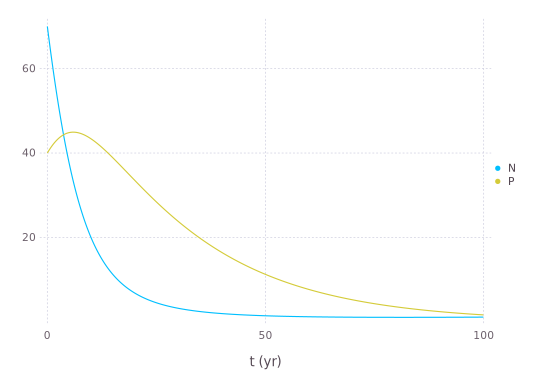

In [ ]:
HW23a = visualize(DDLV_predation, :t, [:N, :P]; config=(cDDLV_p,
    :DDLV_predation => (;
            r = #= .. =#,
            a = #= .. =#,
            c = #= .. =#,
            m = #= .. =#,
            K = #= .. =#,
            N0 = #= .. =#,
            P0 = #= .. =#,
    ),
), stop=100u"yr", snap=100u"d",kind=:line)

### b. Predator dies out and prey does not.
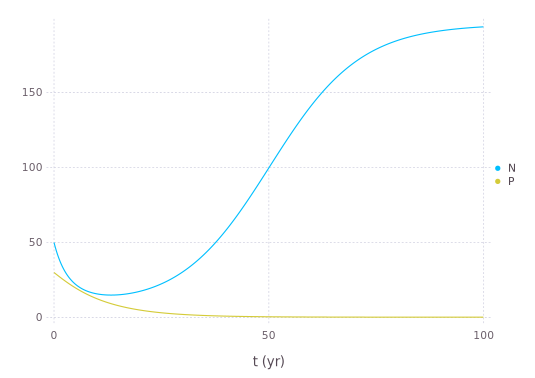

In [ ]:
HW23b = visualize(DDLV_predation, :t, [:N, :P]; config=(cDDLV_p,
    :DDLV_predation => (;
            r = #= .. =#,
            a = #= .. =#,
            c = #= .. =#,
            m = #= .. =#,
            K = #= .. =#,
            N0 = #= .. =#,
            P0 = #= .. =#,
    ),
), stop=100u"yr", snap=100u"d", kind=:line)

### c. Both predator and prey populations oscillate for the entire period.
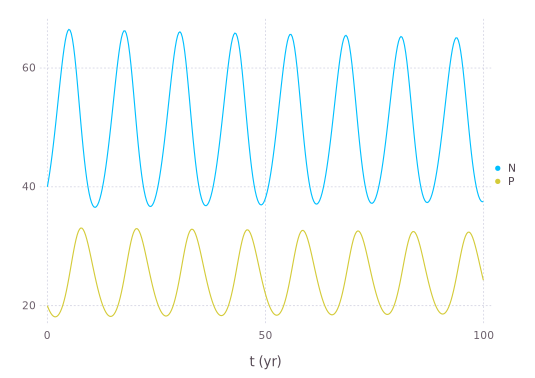

In [ ]:
HW23c = visualize(DDLV_predation, :t, [:N, :P]; config=(cDDLV_p,
    :DDLV_predation => (;
            r = #= .. =#,
            a = #= .. =#,
            c = #= .. =#,
            m = #= .. =#,
            K = #= .. =#,
            N0 = #= .. =#,
            P0 = #= .. =#,
    ),
), stop=100u"yr", snap=100u"d", kind=:line)

### d. Both predator and prey populations stabilize over time to reach an equilibrium.
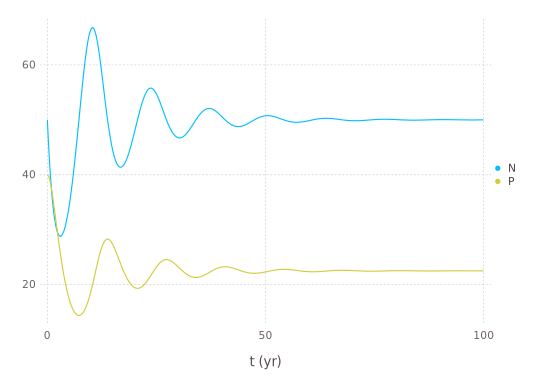

In [ ]:
HW23d = visualize(DDLV_predation, :t, [:N, :P]; config=(cDDLV_p,
    :DDLV_predation => (;
            r = #= .. =#,
            a = #= .. =#,
            c = #= .. =#,
            m = #= .. =#,
            K = #= .. =#,
            N0 = #= .. =#,
            P0 = #= .. =#,
    ),
), stop=100u"yr", snap=100u"d", kind=:line)